# Miniproject: Modelling the climate or the weather?

Is past performance an indicator of future weather?

## Global Historial Climatology Network
GHCN (Global Historical Climatology Network)-Daily is an integrated database of daily climate summaries from land surface stations across the globe. 

THe GHCN has many datasets from weather stations across the globe. A [README describing the data form is available here](http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/readme.txt). The [stations.txt](http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-stations.txt) file and [countries.txt](http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-countries.txt) contain information about the stations and countries.


### Machine Learning Tasks: 
1. Can you design a machine learning technique that can predict the climate (defined as the weekly or monthly average) a year in advance?  [Later in the term files containing the 2021 data will be made available
2. Can you design a machine learning technique that can predict the weather (temperature, rainfall, snow fall, etc.) any better than assuming that the weather tomorrow will be exactly the same as the weather today

### Potential extensions
1. Can you train a machine learning technique to predict 10 or 20 years into the future?
2. Where will the hotest part of the world be in 20 years time?
3. What else can you study with this dataset? Is the sun in Utah a predictor of the rain in Spain? 
4. How close do weather stations need to be to provide reliable forecasts at other stations?

### Caveats
This is real data from weather stations around the world. This means that there are 'holes' in the data. You must be able to handle these 'holes' in some error tolerant fashion.


In [1]:
# import the urllib library
import urllib.request
from datetime import date
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense
mpl.rcParams['figure.dpi']=200
mpl.rc('xtick', labelsize=8) 
mpl.rc('ytick', labelsize=8) 
 
#Class that keeps information about station name and location
class Station():
    def __init__(self,sid,lat,lon,el,state,name,gsn,hcn,wmo,country):
        self.sid=sid
        self.lat=lat
        self.lon=lon
        self.el=el
        self.state=state
        self.name=name
        self.gsn=gsn
        self.hcn=hcn
        self.wmo=wmo
        self.country=country
        
    def __str__(self):
        return self.sid+" is "+self.name+", "+self.country+" at "+str(self.lat)+", "+str(self.lon)+", "+str(self.el)

#Class that hides some ugly reading routines
class GHNCD:
     
    #Class constructor
    def __init__(self): 
        self.station_col_len = [11,4,2,4]
        for i in range(31):
            self.station_col_len.append(5)
            self.station_col_len.append(3)
    
    # Split up the fixed length text arrays into fields
    def chunkstring(self,string, lengths):
        return (string[pos:pos+length].strip() 
                for idx,length in enumerate(lengths)
                for pos in [sum(map(int, lengths[:idx]))])

    # Process a file and extract all the information into a dictionary
    def processFile(self,fileName):
        outDict={} #
        with open(fileName, 'r') as fp: # Open file
            line = fp.readline()  #Read first line
            while line: # Process line
                fields = list(self.chunkstring(line, self.station_col_len)) #Get list of fields
                
                # For clarity use some variable names
                station=fields[0]  
                year=int(fields[1])
                month=int(fields[2])
                field=fields[3]
                vals=fields[4::2]
                flags=fields[5::2]
                # Not clear this is the only check we need, but for now
                def checkInt(x,flag):
                    if flag=='':
                        return -9999
                    return int(x)
                
                #Convert missing entries to -9999 using this swishy bit of string comprehension
                ivals=[checkInt(x,flag) for (x,flag) in zip(vals,flags)]
                monthDict=dict(year=year,month=month,field=field,vals=ivals,flags=flags)
                if field in outDict.keys():
                    outDict[field]['monthList'].append(monthDict)
                else:
                    fieldDict=dict(monthList=[monthDict])
                    outDict[field]=fieldDict
                line = fp.readline()
        return dict(outDict) #Return a copy
    
    def readCountriesFile(self,fileName=None):
        self.countryDict={}
        if fileName==None:
            file = urllib.request.urlopen('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-countries.txt')
        else:
            file = open(fileName,'r')
        
        for line in file:
            c=str(line[0:2], 'utf-8')
            d=str(line[3:-2], 'utf-8')                  
            self.countryDict[c]=d
        print("Read",len(self.countryDict),"countries and codes")
        
    
    def readStationsFile(self,fileName=None,justGSN=True):
        
        #------------------------------
        #Variable   Columns   Type
        #------------------------------
        #ID            1-11   Character
        #LATITUDE     13-20   Real
        #LONGITUDE    22-30   Real
        #ELEVATION    32-37   Real
        #STATE        39-40   Character
        #NAME         42-71   Character
        #GSN FLAG     73-75   Character
        #HCN/CRN FLAG 77-79   Character
        #WMO ID       81-85   Character
        #------------------------------
        self.stationDict={}
        if fileName==None:
            file = urllib.request.urlopen('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-stations.txt')
        else:
            file = open(fileName,'r')
        
        for line in file:
            sid=str(line[0:11], 'utf-8')
            lat=float(str(line[12:20], 'utf-8'))
            lon=float(str(line[21:30], 'utf-8'))
            el=float(str(line[31:37], 'utf-8'))
            state=str(line[38:40], 'utf-8')
            name=str(line[41:71], 'utf-8')
            gsn=str(line[72:75], 'utf-8')
            hcn=str(line[76:79], 'utf-8')
            wmo=str(line[80:85], 'utf-8')
            
           
            if justGSN:
                if gsn=='   ':
                    continue
            self.stationDict[sid]=Station(sid,lat,lon,el,state,name.rstrip(),gsn,hcn,wmo,self.countryDict[sid[0:2]])
        print("Read",len(self.stationDict),"stations with justGSN",justGSN)

    # Get all the data for a given variable type
    def getVar(self,statDict,varName='TMAX'):
        #The TMIN, TMAX, PRCP are all quoted in tenths (so need to be multipied by 0.1)
        cal=0.1
        if varName=='SNOW' or varName=='SNWD':
            cal=1.0
        tempList=[ (date(month['year'],month['month'],ind+1),cal*val)  for month in statDict[varName]['monthList'] for ind, val in enumerate(month['vals']) if val!=-9999   ]
        return tempList
    
    def getTMAX(self,statDict):
        return self.getVar(statDict,'TMAX')
    
    def printStation(self,sid):
        print(self.stationDict[sid])
        
    def getStation(self,sid):
        return self.stationDict[sid]
        
    def getStatKeyNames(self):
        #print(self.stationDict.keys())
        return [*self.stationDict.keys()]
        
    

In [2]:
ghn=GHNCD()
ghn.readCountriesFile()
ghn.readStationsFile()

Read 219 countries and codes
Read 991 stations with justGSN True


In [3]:
# Get list of station names
statNames=ghn.getStatKeyNames()

# Arbitrary number from 0 to 990
whichStat=220
fileName=statNames[whichStat]+'.dly'
urlName='http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/'+fileName

# Copy a network object to a local file
urllib.request.urlretrieve(urlName,fileName)
statDict=ghn.processFile(fileName)
print(ghn.getStation(statNames[whichStat]))


CA002400404 is ARCTIC BAY CS, Canada at 73.0, -85.0167, 10.0


5341


Text(0, 0.5, 'Temperature (C)')

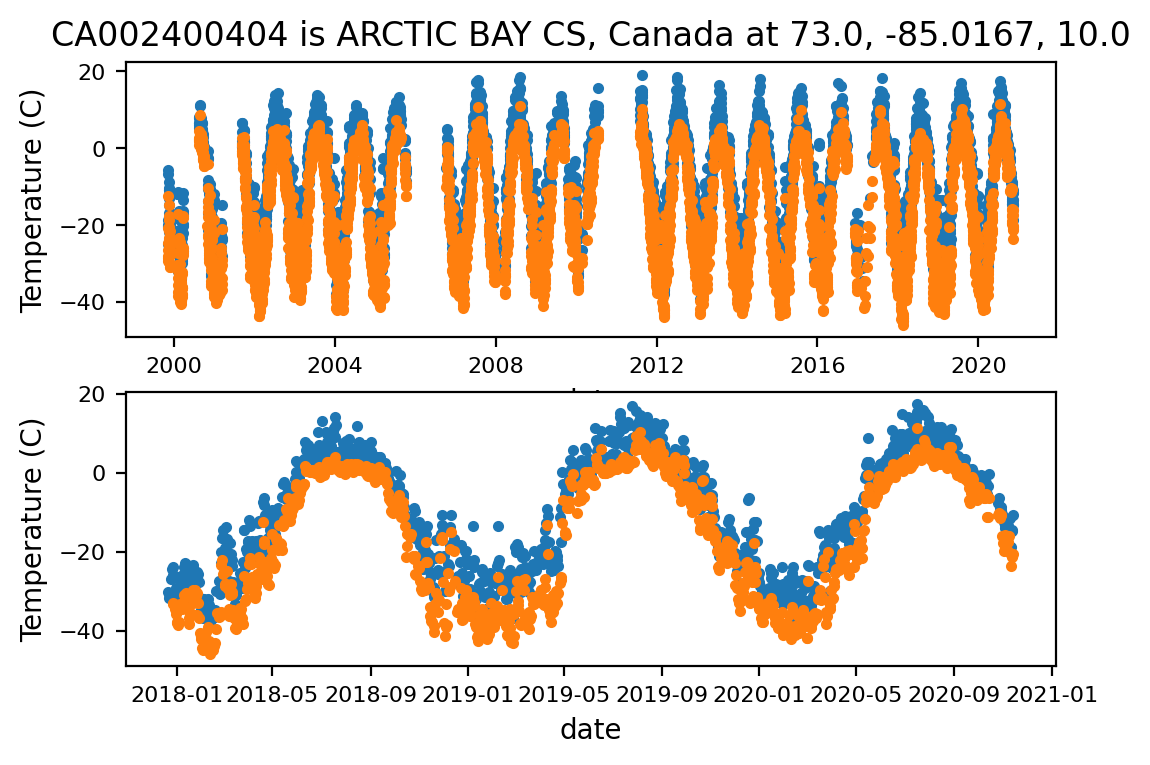

In [4]:
tmaxArray=ghn.getVar(statDict,'TMAX')
days, tmax = zip(*tmaxArray)
tminArray=ghn.getVar(statDict,'TMIN')
days2, tmin = zip(*tminArray)
print(len(days))
fig, ax = plt.subplots(2,1)
ax[0].plot(days,tmax,'.')
ax[0].plot(days2,tmin,'.')
ax[0].set_xlabel("date")
ax[0].set_ylabel("Temperature (C)")
ax[0].set_title(ghn.getStation(statNames[whichStat]))
ax[1].plot(days[-1000:],tmax[-1000:],'.')
ax[1].plot(days2[-1000:],tmin[-1000:],'.')
ax[1].set_xlabel("date")
ax[1].set_ylabel("Temperature (C)")

In [5]:
class getdata:
    '''
    This sets a general set of function for giving each of 5 sorts of data and plot them
    '''
    def Dict(self,Whichstat):
        
        '''
        This function calculates the parameters for referencing the climate respect to the value of Whichstat
        '''
        
        statNames=ghn.getStatKeyNames()
        fileName=statNames[Whichstat]+'.dly'
        urlName='http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/'+fileName

        # Copy a network object to a local file
        urllib.request.urlretrieve(urlName,fileName)
        statDict=ghn.processFile(fileName)
        
        return statDict
        
    def TmaxTmin(self,Whichstat):
        
        '''
        This function outputs the maximum and minimum temperatures at location respect to Whichstat value
        and gives 2 figures of a full plot and last 1000 points respectively
        '''
        
        statNames=ghn.getStatKeyNames()
        tmaxArray=ghn.getVar(self.Dict(Whichstat),'TMAX')
        days, tmax = zip(*tmaxArray)
        tminArray=ghn.getVar(self.Dict(Whichstat),'TMIN')
        days2, tmin = zip(*tminArray)
        fig, ax = plt.subplots(2,1)
        ax[0].plot(days,tmax,'.',label="Maximum Temperature of Days")
        ax[0].plot(days2,tmin,'.',label="Minimum Temperature of Days")
        ax[0].set_xlabel("date")
        ax[0].set_ylabel("Temperature (C)")
        ax[0].legend(loc='best')
        ax[0].set_title(ghn.getStation(statNames[Whichstat]))
        ax[1].plot(days[-1000:],tmax[-1000:],'.',label="Last 1000 data of Maximum")
        ax[1].plot(days2[-1000:],tmin[-1000:],'.',label="Last 1000 data of Minimum")
        ax[1].set_xlabel("date")
        ax[1].set_ylabel("Temperature (C)")
        ax[1].legend(loc='best')
        return days,tmax,days2,tmin,Whichstat
    
    def SNOW(self,Whichstat):
        
        '''
        This function gives the amount of snowfall at location respect to the value of Whichstat and outputs a
        figure of that
        '''
        
        statNames=ghn.getStatKeyNames()
        snowarray=ghn.getVar(self.Dict(Whichstat),'SNOW')
        days,snow = zip(*snowarray)
        fig,ax = plt.subplots(1,1)
        ax.plot(days,snow,'.')
        ax.set_xlabel("date")
        ax.set_ylabel("Snowfall in millimeters")
        ax.set_title(ghn.getStation(statNames[Whichstat]))
        ax.legend(loc='best')
        return days,snow,Whichstat
    
    def SNWD(self,Whichstat):
        
        '''
        This function gives the amount of snow precipitate at location respect to the value of Whichstat
        and outputs a figure of that
        '''
        
        statNames=ghn.getStatKeyNames()
        snwdarray=ghn.getVar(self.Dict(Whichstat),'SNWD')
        days,snwd = zip(*snwdarray)
        fig,ax = plt.subplots(1,1)
        ax.plot(days,snwd,'.')
        ax.set_xlabel("date")
        ax.set_ylabel("Snow Precipitate in millimeters")
        ax.set_title(ghn.getStation(statNames[Whichstat]))
        ax.legend(loc='best')
        return days,snwd,Whichstat
        
    def PRCP(self,Whichstat):
        
        '''
        This function gives the amount of rainfall precipitate at location respect to the value of Whichstat
        and outputs a figure of that
        '''
        
        statNames=ghn.getStatKeyNames()
        PCRParray=ghn.getVar(self.Dict(Whichstat),'PRCP')
        days,prcp = zip(*PCRParray)
        fig,ax = plt.subplots(1,1)
        ax.plot(days,prcp,'.')
        ax.set_xlabel("date")
        ax.set_ylabel("Rainfall Precipitate in millimeters")
        ax.set_title(ghn.getStation(statNames[Whichstat]))
        ax.legend(loc='best')
        return days,prcp,Whichstat

# Name this class thing
data = getdata()

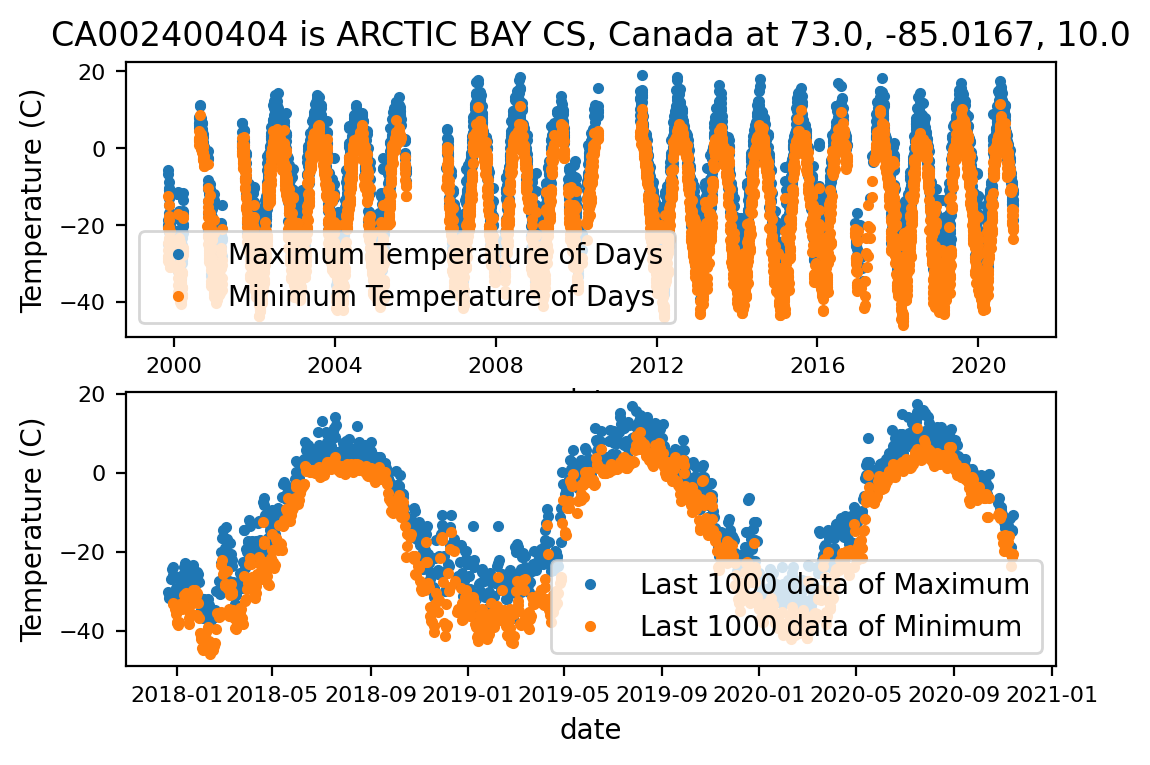

In [6]:
Tm=data.TmaxTmin(220)

In [7]:
from sklearn.ensemble import GradientBoostingRegressor
import pandas as pd
import tensorflow as tf
from tensorflow import keras

def fillholesT (Temp):
    
    # assume dates is a list of datetime.date objects
    datesmax = Temp[0]
    datesmin = Temp[2]
    
    # create an empty numpy array to store the converted dates
    converted_datesmax = np.empty(len(datesmax), dtype='datetime64[D]')
    converted_datesmin = np.empty(len(datesmin), dtype='datetime64[D]')
    
    # loop through the dates and convert each one
    for i, datesmax in enumerate(datesmax):
        converted_datesmax[i] = np.datetime64(datesmax)
    for i, datesmin in enumerate(datesmin):
        converted_datesmin[i] = np.datetime64(datesmin)
        
    datesmax = np.array(converted_datesmax)
    dates_strmax = np.datetime_as_string(datesmax)
    
    datesmin = np.array(converted_datesmin)
    dates_strmin = np.datetime_as_string(datesmin)
    
    # create a DataFrame with the given dates
    dfmax = pd.DataFrame({'temperature': Temp[1]}, index=pd.to_datetime(dates_strmax))
    dfmin = pd.DataFrame({'temperature': Temp[3]}, index=pd.to_datetime(dates_strmin))
    
    # set the 'date' column as the index
    dfmax = dfmax.resample('D').asfreq()
    dfmin = dfmin.resample('D').asfreq()
    
    # Fill the NaN values with 0
    dfmax.fillna(np.nan)
    dfmin.fillna(np.nan)
    
    zerosmax = dfmax['temperature'].values
    zerosmin = dfmin['temperature'].values
    
    datearrmax = dfmax.index.values
    datearrmin = dfmin.index.values
    
    maxtrain = dfmax.dropna()
    mintrain = dfmin.dropna()
    
    tmaxtrain = maxtrain['temperature'].values
    tmintrain = mintrain['temperature'].values
    dmaxtrain = maxtrain.index.values.reshape(-1,1)
    dmintrain = mintrain.index.values.reshape(-1,1)
    
    dmaxpred = dfmax[dfmax['temperature'].isna()].index.values.reshape(-1,1)
    dminpred = dfmin[dfmin['temperature'].isna()].index.values.reshape(-1,1)
    
    # use a Gradient Boosting Regressor model instead of RandomForestRegressor
    gbmax = GradientBoostingRegressor(n_estimators=1000, max_depth=10)
    gbmax.fit(dmaxtrain, tmaxtrain)
    
    gbmin = GradientBoostingRegressor(n_estimators=1000, max_depth=10)
    gbmin.fit(dmintrain, tmintrain)

    tmaxpred = gbmax.predict(dmaxpred)
    tminpred = gbmin.predict(dminpred)
    
    dfmax.loc[dfmax['temperature'].isna(), 'temperature'] = tmaxpred
    dfmin.loc[dfmin['temperature'].isna(), 'temperature'] = tminpred
    
    Filledmax = np.array(dfmax['temperature'].values)
    Filledmin = np.array(dfmin['temperature'].values)
    
    fig, ax = plt.subplots(2,1)
    ax[0].plot(datearrmax,Filledmax,'.',label="T max without Holes")
    ax[0].plot(datearrmin,Filledmin,'.',label="T min without Holes")
    ax[0].set_xlabel("date")
    ax[0].set_ylabel("Temperature (C)")
    ax[0].legend(loc='best')
    ax[0].set_title(ghn.getStation(statNames[Temp[4]]))
    ax[1].plot(datearrmax[-2000:],Filledmax[-2000:],'.',label="Last 2k T max")
    ax[1].plot(datearrmin[-2000:],Filledmin[-2000:],'.',label="Last 2k T min")
    ax[1].set_xlabel("date")
    ax[1].set_ylabel("Temperature (C)")
    ax[1].legend(loc='best')
    
    return datearrmax,Filledmax,datearrmin,Filledmin

In [8]:
from tqdm import tqdm
from sklearn.model_selection import train_test_split
def shapeArray(x,windowsize,offset):

    xInput= np.array([x[i : i + windowsize] for i in range(len(x)-(windowsize+offset)+1)])
    xLabel= np.array([x[i +windowsize : i+ windowsize+offset] for i in range(len(x)-(windowsize+offset)+1)])
    return (xInput,xLabel)



def pre_fut (data,windowsize,offset):
    
    min_temp = np.min(data)
    max_temp = np.max(data)
    value = (data - min_temp) / (max_temp - min_temp)
    
    yInput,yLabel=shapeArray(value,windowsize,offset)
    yInput_train,yInput_test,yLabel_train,yLabel_test = train_test_split(yInput,yLabel, test_size=0.2, random_state=0, shuffle=False)
    model=keras.models.Sequential()
    model.add(keras.layers.LSTM(50,input_shape=(None, 1),return_sequences=True)) 
    model.add(keras.layers.LSTM(50))
    model.add(keras.layers.Dense(1))
    model.compile(loss='mean_squared_error',optimizer='adam')
    model.fit(yInput_train,yLabel_train ,batch_size=100,epochs=10)
    
    predictdata = model.predict(yInput_test)
    predictdata = np.array(predictdata) * (max_temp - min_temp) + min_temp
    yLabel_test = np.array(yLabel_test) * (max_temp - min_temp) + min_temp
    plt.plot(yLabel_test.reshape(yLabel_test.shape[0],yLabel_test.shape[1]),'.',label='original')
    plt.plot(predictdata,'.',label='predict')
    plt.legend(loc='best')
    return predictdata

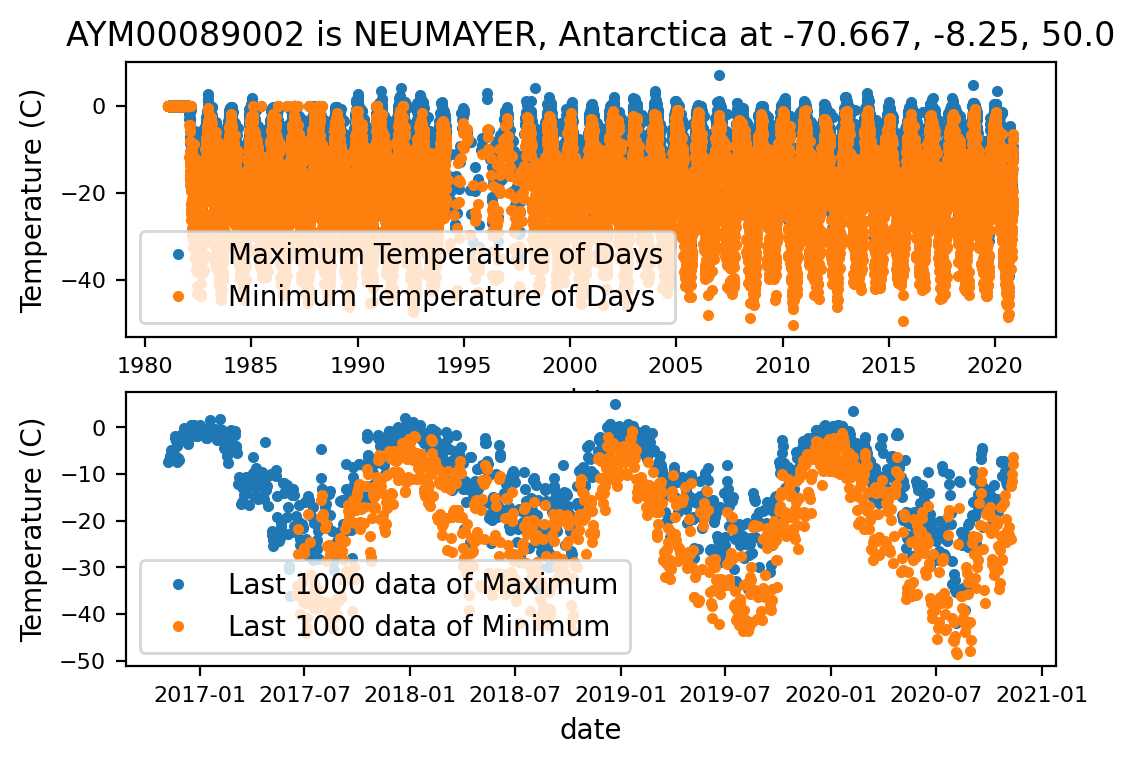

In [9]:
test=data.TmaxTmin(110)

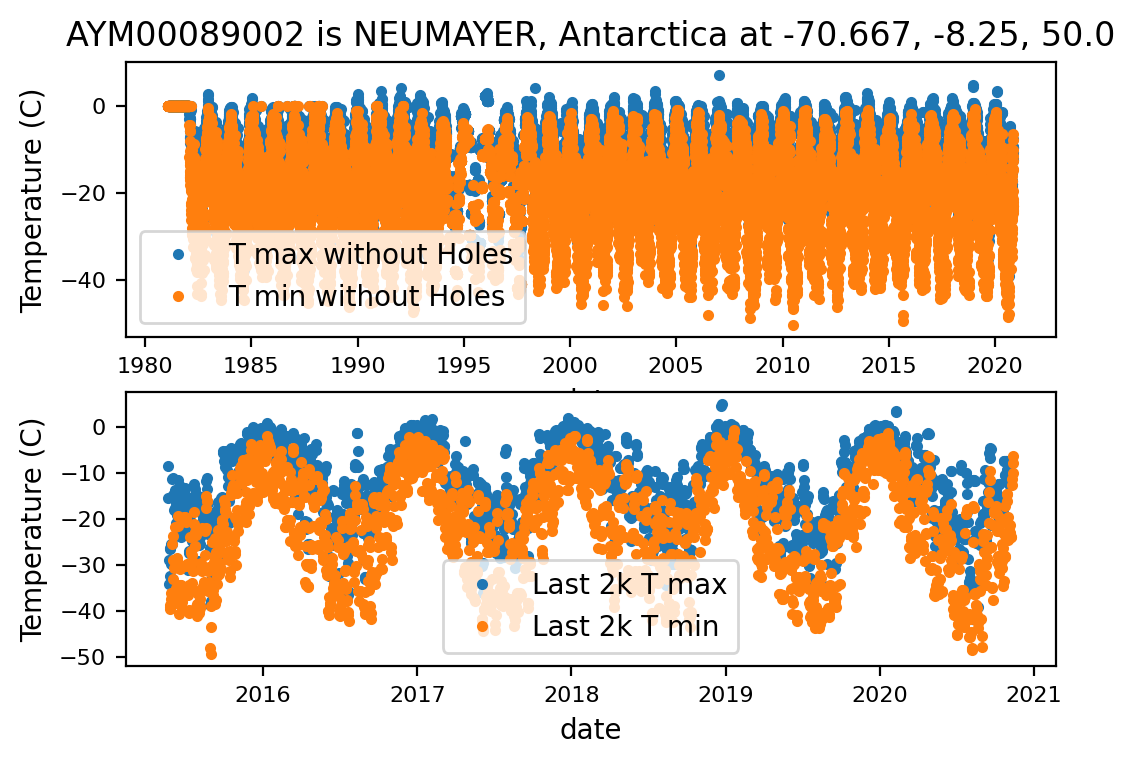

In [10]:
test1 = fillholesT(test)

Epoch 1/10
85/85 [==============================] - 11s 71ms/step - loss: 0.0335
Epoch 2/10
85/85 [==============================] - 5s 59ms/step - loss: 0.0107
Epoch 3/10
85/85 [==============================] - 6s 68ms/step - loss: 0.0103
Epoch 4/10
85/85 [==============================] - 5s 62ms/step - loss: 0.0099
Epoch 5/10
85/85 [==============================] - 5s 60ms/step - loss: 0.0094
Epoch 6/10
85/85 [==============================] - 8s 91ms/step - loss: 0.0088
Epoch 7/10
85/85 [==============================] - 5s 62ms/step - loss: 0.0083
Epoch 8/10
85/85 [==============================] - 7s 77ms/step - loss: 0.0075
Epoch 9/10
85/85 [==============================] - 6s 74ms/step - loss: 0.0070
Epoch 10/10
67/67 [==============================] - 2s 12ms/step


array([[-10.761295 ],
       [-10.346674 ],
       [-16.322334 ],
       ...,
       [-11.006199 ],
       [-11.1299515],
       [-10.989773 ]], dtype=float32)

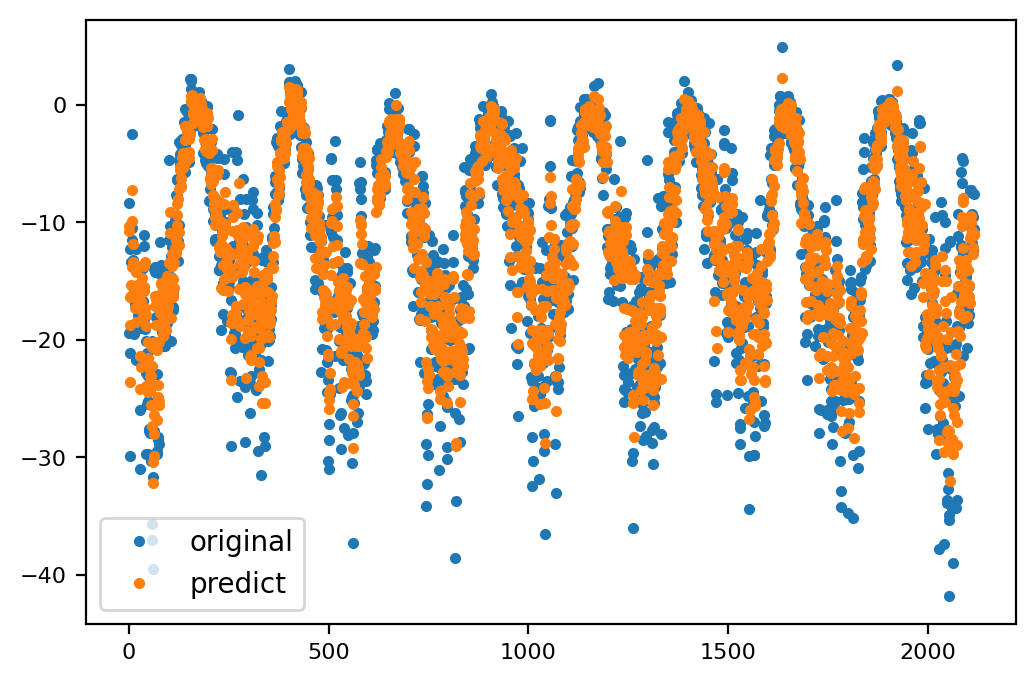

In [11]:
pre_fut(test[1],30,1)